# Workshop: Introdução à arquitetura Transformer e Visual Transformers para aplicações em saúde

In [1]:
import re
import torch
import pandas as pd
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt

from pprint import pprint
from collections import Counter
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

## 1. Preliminares: transformando texto em números

Redes Neurais necessitam de números! Como representar texto desta maneira?

![Transformação de texto em números](figures/tokenization.png "Tranformação de texto em números")

### 1.1 Tokenização

In [2]:
df = pd.read_csv('../exemplos/data/transcription.csv')
sentences = df['transcription'].dropna().astype(str).values

sample = sentences[0]
pprint(sample)
print(f"\nEspecialidade: {df['medical_specialty'][0]}")

('SUBJECTIVE:,  This 23-year-old white female presents with complaint of '
 'allergies.  She used to have allergies when she lived in Seattle but she '
 'thinks they are worse here.  In the past, she has tried Claritin, and '
 'Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  '
 'She has used Allegra also.  She used that last summer and she began using it '
 'again two weeks ago.  It does not appear to be working very well.  She has '
 'used over-the-counter sprays but no prescription nasal sprays.  She does '
 'have asthma but doest not require daily medication for this and does not '
 'think it is flaring up.,MEDICATIONS: , Her only medication currently is '
 'Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine '
 'allergies.,OBJECTIVE:,Vitals:  Weight was 130 pounds and blood pressure '
 '124/78.,HEENT:  Her throat was mildly erythematous without exudate.  Nasal '
 'mucosa was erythematous and swollen.  Only clear drainage was seen.  T

### Tokenização: nível de caractere

In [3]:
class CharacterLevelTokenizer:
    def __init__(self):
        self.token_to_idx = {}
        self.idx_to_token = {}

    def clean_sentence(self, sentence):
        return str(sentence).lower()

    def build_vocab(self, sentences):
        unique_chars = set()

        for sentence in sentences:
            cleaned_sentence = self.clean_sentence(sentence)
            unique_chars.update(list(cleaned_sentence))

        self.token_to_idx = {'[PAD]': 0, '[UNK]': 1, '[CLS]': 2, '[SEP]': 3} # Tokens especiais
        for i, char in enumerate(sorted(list(unique_chars)), 4):
            self.token_to_idx[char] = i

        self.idx_to_token = {i: c for c, i in self.token_to_idx.items()}

    def tokenize(self, sentence):
        cleaned_sentence = self.clean_sentence(sentence)
        return list(cleaned_sentence)

    def convert_tokens_to_ids(self, tokens):
        return [self.token_to_idx.get(token, self.token_to_idx['[UNK]']) for token in tokens]

    def get_vocab_size(self):
        return len(self.token_to_idx)

tokenizer = CharacterLevelTokenizer()
tokenizer.build_vocab(sentences)
print(f"\nTamanho do vocabulário: {tokenizer.get_vocab_size()}")


Tamanho do vocabulário: 84


In [4]:
tokens = tokenizer.tokenize("She has a terrible disease")
print(tokens)

['s', 'h', 'e', ' ', 'h', 'a', 's', ' ', 'a', ' ', 't', 'e', 'r', 'r', 'i', 'b', 'l', 'e', ' ', 'd', 'i', 's', 'e', 'a', 's', 'e']


In [5]:
class MostFrequentWordsTokenizer:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.token_to_idx = {}
        self.idx_to_token = {}

    def clean_sentence(self, sentence):
        sentence = sentence.lower()
        return re.sub(r'[^a-z0-9\s]', '', sentence)

    def build_vocab(self, sentences):
        words = []
        for sentence in sentences:
            cleaned_sentence = self.clean_sentence(sentence)
            new_words = cleaned_sentence.split()
            words.extend(new_words)

        word_counts = Counter(words)
        most_common_words = word_counts.most_common(self.vocab_size - 4)

        self.token_to_idx = {'[PAD]': 0, '[UNK]': 1, '[CLS]': 2, '[SEP]': 3} # Tokens especiais
        for i, (word, _) in enumerate(most_common_words, 4):
            self.token_to_idx[word] = i

        self.idx_to_token = {i: w for w, i in self.token_to_idx.items()}

    def tokenize(self, sentence):
        cleaned_sentence = self.clean_sentence(str(sentence))
        return cleaned_sentence.split()

    def convert_tokens_to_ids(self, tokens):
        return [self.token_to_idx.get(token, self.token_to_idx['[UNK]']) for token in tokens]
    
    def get_vocab_size(self):
        return len(self.token_to_idx)
    
tokenizer = MostFrequentWordsTokenizer(vocab_size=256)
tokenizer.build_vocab(sentences)

In [6]:
tokenizer.tokenize("She has a terrible disease")

['she', 'has', 'a', 'terrible', 'disease']

### Nível de sub-palavras

In [7]:
class BytePairEncodingTokenizer:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
        self.tokenizer.pre_tokenizer = Whitespace()
        self.special_tokens = ["[PAD]", "[UNK]", "[CLS]", "[SEP]"] # Tokens especiais

    def build_vocab(self, sentences):
        trainer = BpeTrainer(vocab_size=self.vocab_size, special_tokens=self.special_tokens)
        self.tokenizer.train_from_iterator(sentences, trainer=trainer)

    def tokenize(self, text):
        return self.tokenizer.encode(text).tokens

    def convert_tokens_to_ids(self, tokens):
        return [self.tokenizer.token_to_id(token) for token in tokens]
    
    def get_vocab_size(self):
        return self.tokenizer.get_vocab_size()
    
tokenizer = BytePairEncodingTokenizer(vocab_size=1024)
tokenizer.build_vocab(sentences)


In [8]:
tokens = tokenizer.tokenize("She has a terrible disease")
pprint(tokens)

['She', 'has', 'a', 'ter', 'r', 'ib', 'le', 'disease']


## Conversão para IDs

In [9]:
tokenizer = MostFrequentWordsTokenizer(vocab_size=256)
tokenizer.build_vocab(sentences)

tokens = tokenizer.tokenize("She has a terrible disease")
print(tokenizer.convert_tokens_to_ids(tokens))

[15, 24, 9, 1, 112]


## Embeddings

In [10]:
VOCAB_SIZE = 256
EMBEDDING_DIM = 768

tokenizer = MostFrequentWordsTokenizer(vocab_size=256)
tokenizer.build_vocab(sentences)

embedding_texto = nn.Embedding(num_embeddings=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM)

In [11]:
tokens = tokenizer.tokenize("She is ok")
token_ids = tokenizer.convert_tokens_to_ids(tokens)
embeddings = embedding_texto(torch.tensor(token_ids))

print(f'Dimensões dos embeddings: {embeddings.shape}\n')

Dimensões dos embeddings: torch.Size([3, 768])



In [12]:
embeddings

tensor([[ 0.6057,  1.1751,  0.0448,  ...,  0.9011, -0.3232, -0.1657],
        [ 0.4545,  0.4155,  0.4295,  ..., -0.1992, -0.4127, -0.0230],
        [ 0.2662,  0.1530,  1.4343,  ...,  0.0171,  1.0616,  0.9122]],
       grad_fn=<EmbeddingBackward0>)

### Truncamento e padding

In [13]:
class MostFrequentWordsTokenizer:
    def __init__(self, vocab_size, max_len=128):
        self.vocab_size = vocab_size
        self.token_to_idx = {}
        self.idx_to_token = {}
        self.max_len = max_len

    def clean_sentence(self, sentence):
        sentence = sentence.lower()
        return re.sub(r'[^a-z0-9\s]', '', sentence)

    def build_vocab(self, sentences):
        words = []
        for sentence in sentences:
            words.extend(self.clean_sentence(str(sentence)).split())

        word_counts = Counter(words)
        most_common_words = word_counts.most_common(self.vocab_size - 4)
        
        self.token_to_idx = {'[PAD]': 0, '[UNK]': 1, '[CLS]': 2, '[SEP]': 3} # Tokens especiais
        for i, (word, _) in enumerate(most_common_words, 4):
            self.token_to_idx[word] = i

        self.idx_to_token = {i: w for w, i in self.token_to_idx.items()}

    def tokenize(self, sentence):
        cleaned_sentence = self.clean_sentence(str(sentence))
        return cleaned_sentence.split()

    def convert_tokens_to_ids(self, tokens):
        return [self.token_to_idx.get(token, self.token_to_idx['[UNK]']) for token in tokens]
    
    def encode(self, sentence):
        tokens = self.tokenize(sentence)

        # Truca sequencia se maior que max_len
        if len(tokens) > self.max_len:
            tokens = tokens[:self.max_len]

        # Completa com [PAD] se menor que max_len
        padding_len = self.max_len - len(tokens)
        tokens.extend(['[PAD]'] * padding_len)
        
        print(tokens)
        return self.convert_tokens_to_ids(tokens)
    
    def decode(self, ids):
        return ' '.join([self.idx_to_token.get(i, '[UNK]') for i in ids])

    def get_vocab_size(self):
        return len(self.token_to_idx)

### Tamanho máximo de sequência

In [14]:
SEQUENCE_SIZE = 12

embedding_texto = nn.Embedding(num_embeddings=8000, embedding_dim=EMBEDDING_DIM)
tokenizer = MostFrequentWordsTokenizer(vocab_size=8000, max_len=SEQUENCE_SIZE)
tokenizer.build_vocab(sentences)

print('Tokens:')
token_ids = [tokenizer.encode(text) for text in [
  "she has the flu",
  "he is sick",
  "they have travelled to china in the last weekeend, they could have been infected with covid-19."
]]

print('\nToken IDs:')
print(token_ids)

print('\nShape Embeddings:')
print(embedding_texto(torch.tensor(token_ids)).shape)


Tokens:
['she', 'has', 'the', 'flu', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
['he', 'is', 'sick', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
['they', 'have', 'travelled', 'to', 'china', 'in', 'the', 'last', 'weekeend', 'they', 'could', 'have']

Token IDs:
[[15, 24, 4, 4608, 0, 0, 0, 0, 0, 0, 0, 0], [18, 12, 2883, 0, 0, 0, 0, 0, 0, 0, 0, 0], [222, 49, 1, 8, 1, 11, 4, 218, 1, 222, 252, 49]]

Shape Embeddings:
torch.Size([3, 12, 768])


## Embeddings Posicionais

### Embedding Posicionais: parâmetros

```python

In [15]:
embeddings_posicionais = nn.Embedding(SEQUENCE_SIZE, EMBEDDING_DIM)

embeddings = embedding_texto(torch.tensor([5])) + embeddings_posicionais(torch.tensor([0]))

### Embeddings Posicionais: senóides

$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)$$
$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)$$

SEQUENCE_SIZE X EMBEDDING_DIM
(pos, i) -> 
  pos -> 0, SEQUENCE_SIZE -1, 
  i -> 0, EMBBEDDIM_DIM - 1 

In [16]:
class SinusoidalPositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        
        positional_embeddings = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        indices = torch.arange(0, d_model, 2).float()
        exponent = indices / d_model
        denominator = torch.pow(10000, exponent)
        argument = position / denominator
        positional_embeddings[:, 0::2] = torch.sin(argument)
        positional_embeddings[:, 1::2] = torch.cos(argument)
        
        self.register_buffer('positional_embeddings', positional_embeddings.unsqueeze(0))

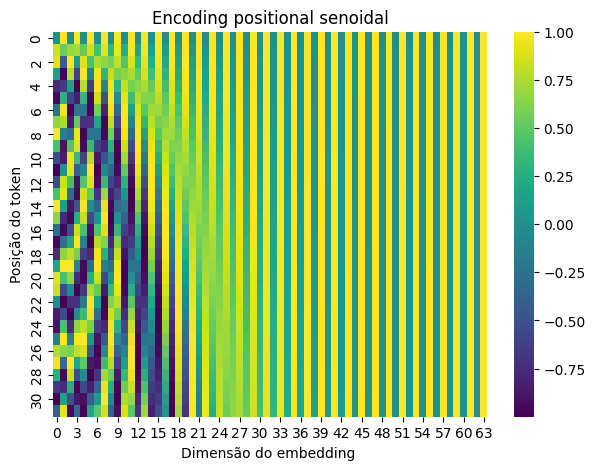

In [17]:
def plot_positional_embeddings():
    d_model = 64
    max_len = 32
    
    pos_encoder = SinusoidalPositionalEmbedding(d_model, max_len)
    
    pe_matrix = pos_encoder.positional_embeddings.squeeze(0).numpy()
    plt.figure(figsize=(7, 5))
    sns.heatmap(pe_matrix, cmap="viridis", cbar=True)
    plt.title("Encoding positional senoidal")
    plt.xlabel("Dimensão do embedding ")
    plt.ylabel("Posição do token")
    plt.show()

plot_positional_embeddings()

### Analogia com números binários

\begin{array}{|c|c|c|c|}
\hline
\textbf{Número} & \textbf{$2^2$} & \textbf{$2^1$} & \textbf{$2^0$} \\
\hline
\textbf{0} & 0 & 0 & 0 \\
\textbf{1} & 0 & 0 & 1 \\
\textbf{2} & 0 & 1 & 0 \\
\textbf{3} & 0 & 1 & 1 \\
\textbf{4} & 1 & 0 & 0 \\
\textbf{5} & 1 & 0 & 1 \\
\hline
\end{array}

### Vamos manter simples!

In [18]:
embeddings_posicionais = nn.Embedding(SEQUENCE_SIZE, EMBEDDING_DIM)